In [73]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os
import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import RepeatVector
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
# fix random seed for reproducibility
tf.random.set_seed(8)

Num GPUs Available:  1


In [74]:
# Hyperparameter
TRAIN_TEST_RATIO = 0.75
TIME_STEP = 2
MODEL_TYPE = "CNN_LSTM_DNN"
EPOCH_SIZE = 1000
BATCH_SIZE = 16
FEATURE_NUMBER = 3
MODEL_JSON = {}
def to_string():
    print_list = [
        f"Time step: {TIME_STEP}",
        f"Ratio: {TRAIN_TEST_RATIO}",
        f"Model type: {MODEL_TYPE}",
        f"Epoch size: {EPOCH_SIZE}",
        f"Batch size: {BATCH_SIZE}",
        f"Model json: {MODEL_JSON}",
    ]
    return "\n".join(print_list)

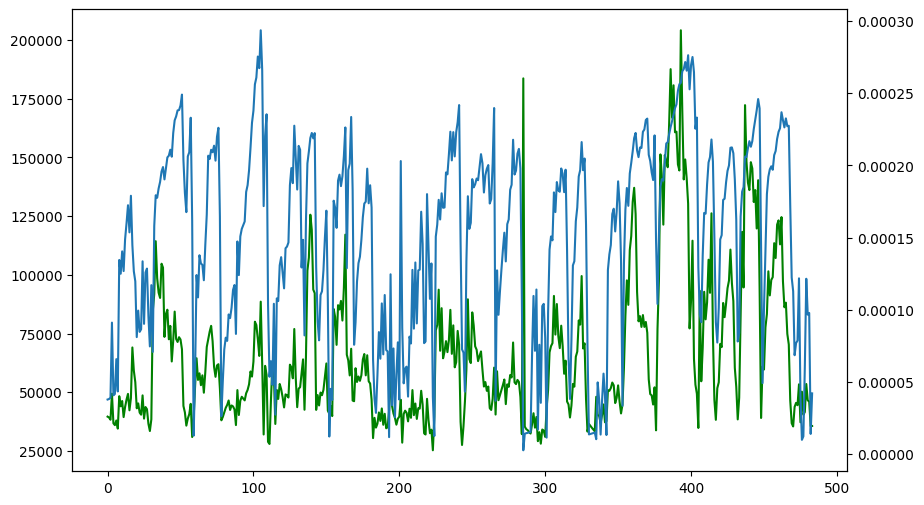

In [75]:
dataframe = pd.read_excel('Data/Data_for_ML_TT-DB.xlsx', sheet_name="Sheet1", header=1, usecols=[0,1,2])
dataset = dataframe.values
# dataset = np.reshape(dataset, (-1, 3))

#Preprocessing
for i in range(dataset.shape[0]):
    dataset[i][0] = int(dataset[i][0][3:5])
# dataset[np.isnan(dataset)] = 0

dataset = dataset.astype('float64')
# plt.clf()
plt.figure(figsize=(10,6))
plt.plot(dataset[:,1], color="green")
plt.twinx()
plt.plot(dataset[:,2])
plt.rcParams.update({'font.size': 10})
plt.show()

Normalize the dataset, when working with sigmoid or tanh function as activation function, normalize data to range 0, 1

In [76]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [77]:
# split into train and test sets
train_size = int(len(dataset) * TRAIN_TEST_RATIO)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

from sklearn.decomposition import PCA
 


363 121


In [78]:

pca = PCA(n_components = 2)
FEATURE_NUMBER = 2
print(train.shape)
train_x = pca.fit_transform(train)
test_x = pca.transform(test)
print(train_x.shape)
print(test_x.shape)

(363, 3)
(363, 2)
(121, 2)


In [79]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, y_col=0):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), :]
		dataX.append(a)
		dataY.append(dataset[i + look_back, y_col])
	return np.array(dataX), np.array(dataY)

In [80]:
# reshape into X=t and Y=t+1
# train_x, train_y = create_dataset(train, TIME_STEP)
# test_x, test_y = create_dataset(test, TIME_STEP)
train_x, _ = create_dataset(train_x, TIME_STEP)
test_x, _ = create_dataset(test_x, TIME_STEP)
_, train_y = create_dataset(train, TIME_STEP,2)
_, test_y = create_dataset(test, TIME_STEP,2)
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(360, 2, 2)
(360,)
(118, 2, 2)
(118,)


In [81]:
# reshape input to be [samples, time steps, features]
train_x = np.reshape(train_x, (train_x.shape[0], TIME_STEP, FEATURE_NUMBER))
test_x = np.reshape(test_x, (test_x.shape[0], TIME_STEP, FEATURE_NUMBER))
print(train_x.shape)
print(test_x.shape)


(360, 2, 2)
(118, 2, 2)


In [82]:
# create and fit the LSTM network
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                min_delta=0.00001, 
                                # patience=int(EPOCH_SIZE*0.05), 
                                patience=int(15), 
                                verbose=0, 
                                mode='auto', 
                                baseline=None, 
                                restore_best_weights=True)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model = Sequential()
if MODEL_TYPE == "LSTM":
    model.add(LSTM(32, input_shape=(TIME_STEP, FEATURE_NUMBER), return_sequences=True))
    model.add(LSTM(32, input_shape=(TIME_STEP, FEATURE_NUMBER)))
    model.add(Dense(1))
elif MODEL_TYPE == "CNN":
    model.add(Conv1D(32, (3), activation='relu', input_shape=(TIME_STEP,FEATURE_NUMBER)))
    # model.add(layers.MaxPooling1D((2)))
    model.add(Conv1D(64, (3), activation='relu'))
    # model.add(layers.MaxPooling1D((2)))
    model.add(Conv1D(64, (3), activation='relu'))
    model.add(MaxPooling1D((2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
elif MODEL_TYPE == "CNN_LSTM":
    model.add(
        Conv1D(6, (3), activation="relu", input_shape=(TIME_STEP, 1))
    )
    model.add(LSTM(300, "relu", input_shape=(TIME_STEP, 1)))
    model.add(Dense(1))
elif MODEL_TYPE == "CNN_LSTM_DNN":
    model.add(
        Conv1D(64, (2), activation="relu", input_shape=(TIME_STEP, FEATURE_NUMBER))
    )
    model.add(
        LSTM(
            32, "relu", input_shape=(TIME_STEP, FEATURE_NUMBER), return_sequences=True
        )
    )
    model.add(LSTM(32, "relu", input_shape=(TIME_STEP, FEATURE_NUMBER)))
    model.add(Dense(16))
    model.add(Dense(8))
    model.add(Dense(1))
elif MODEL_TYPE == "CNN_LSTM_DNN2":
    model.add(
        Conv1D(128, (2), activation="relu", input_shape=(TIME_STEP, FEATURE_NUMBER))
    )
    model.add(
        LSTM(
            200,"relu", input_shape=(TIME_STEP, FEATURE_NUMBER), return_sequences=True
        )
    )
    model.add(LSTM(100,"relu", input_shape=(TIME_STEP, FEATURE_NUMBER)))
    model.add(Dense(16))
    model.add(Dense(8))
    model.add(Dense(1))
elif MODEL_TYPE == "LSTM_DNN":
    model.add(
        LSTM(
            32, "relu", input_shape=(TIME_STEP, FEATURE_NUMBER), return_sequences=True
        )
    )
    model.add(Dropout(0.2))
    model.add(
        LSTM(
            32, "relu", input_shape=(TIME_STEP, FEATURE_NUMBER), return_sequences=True
        )
    )
    model.add(LSTM(32, "relu", input_shape=(TIME_STEP, FEATURE_NUMBER)))
    model.add(Dense(16))
    model.add(Dense(8))
    model.add(Dense(1))
elif MODEL_TYPE == "LSTM_DNN2":
    model.add(LSTM(300, "relu", input_shape=(TIME_STEP, 1)))
    model.add(Dense(16))
    model.add(Dense(1))
elif MODEL_TYPE == "LSTM_DNN3":
    model.add(LSTM(300, "relu", input_shape=(TIME_STEP, 1), return_sequences=True))
    model.add(LSTM(300, "relu", input_shape=(TIME_STEP, 1)))
    model.add(Dense(32))
    model.add(Dense(1))
elif MODEL_TYPE == "LSTM_DNN4":
    model.add(LSTM(300, "relu", input_shape=(TIME_STEP, 1), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(300, "relu", input_shape=(TIME_STEP, 1)))
    model.add(Dense(32))
    model.add(Dense(1))
elif MODEL_TYPE == "LSTM_DNN5":
    model.add(LSTM(300, "relu", input_shape=(TIME_STEP, 1)))
    model.add(Dense(1))
model.summary()
MODEL_JSON = model.to_json()
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_x, train_y, epochs=EPOCH_SIZE, batch_size=BATCH_SIZE, verbose=2, callbacks=[early_stopping, tensorboard_callback])
%tensorboard --logdir logs/fit

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 1, 64)             320       
                                                                 
 lstm_10 (LSTM)              (None, 1, 32)             12416     
                                                                 
 lstm_11 (LSTM)              (None, 32)                8320      
                                                                 
 dense_15 (Dense)            (None, 16)                528       
                                                                 
 dense_16 (Dense)            (None, 8)                 136       
                                                                 
 dense_17 (Dense)            (None, 1)                 9         
                                                                 
Total params: 21,729
Trainable params: 21,729
Non-trai

UsageError: Line magic function `%tensorboard` not found.


In [83]:
# save model
version = 0
for dir in os.scandir(f"./Model2/"):
    if dir.is_dir():
        version = int(dir.name) if int(dir.name) > version else version
version += 1
model.save(f"./Model2/{version}")

INFO:tensorflow:Assets written to: ./Model2/18\assets


INFO:tensorflow:Assets written to: ./Model2/18\assets


In [84]:
# predictions
train_predict = model.predict(train_x)
test_predict = model.predict(test_x)

# invert predictions
# train_predict = scaler.inverse_transform(train_predict)
# train_true = scaler.inverse_transform([trainY])
# test_predict = scaler.inverse_transform(test_predict)
# test_true = scaler.inverse_transform([testY])
train_predict = train_predict
train_true = np.reshape(train_y,(1,-1))
test_predict = test_predict
test_true = np.reshape(test_y,(1,-1))

# calculate root mean squared error (RMSE)
trainScore = np.sqrt(mean_squared_error(train_true[0], train_predict[:, 0]))
train_score_percentage = np.sqrt(
    np.mean(
        np.square(((train_true[0] - train_predict[:, 0]) / train_true[0])),
        axis=0,
    )
)
test_score_percentage = np.sqrt(
    np.mean(
        np.square(((test_true[0] - test_predict[:, 0]) / test_true[0])),
        axis=0,
    )
)
train_score_percentage_output = (
    "Train RMSPE: %.4f RMSPE" % train_score_percentage
)
test_score_percentage_output = "Test RMSPE: %.4f RMSPE" % test_score_percentage
train_score_output = "Train Score: %.4f RMSE" % (trainScore)
testScore = np.sqrt(mean_squared_error(test_true[0], test_predict[:, 0]))
test_score_output = "Test Score: %.4f RMSE" % (testScore)
print(train_score_output)
print(test_score_output)
print(train_score_percentage_output)
print(test_score_percentage_output)
rmse_file = open(
    f"./Model2/{version}/info.md", "w"
)
rmse_file.write(
    train_score_output
    + "\n"
    + test_score_output
    + "\n"
    + train_score_percentage_output
    + "\n"
    + test_score_percentage_output
    + "\n"
    + to_string()
)
rmse_file.close()

4/4 [==============================] - 0s 19ms/step
Train Score: 0.1100 RMSE
Test Score: 0.1021 RMSE
Train RMSPE: inf RMSPE
Test RMSPE: 1.1762 RMSPE


C:\Users\Admin\AppData\Local\Temp\ipykernel_22988\4187468304.py:19: RuntimeWarning: divide by zero encountered in divide
  np.square(((train_true[0] - train_predict[:, 0]) / train_true[0])),


(484, 1)
(484, 1)


<Figure size 640x480 with 0 Axes>

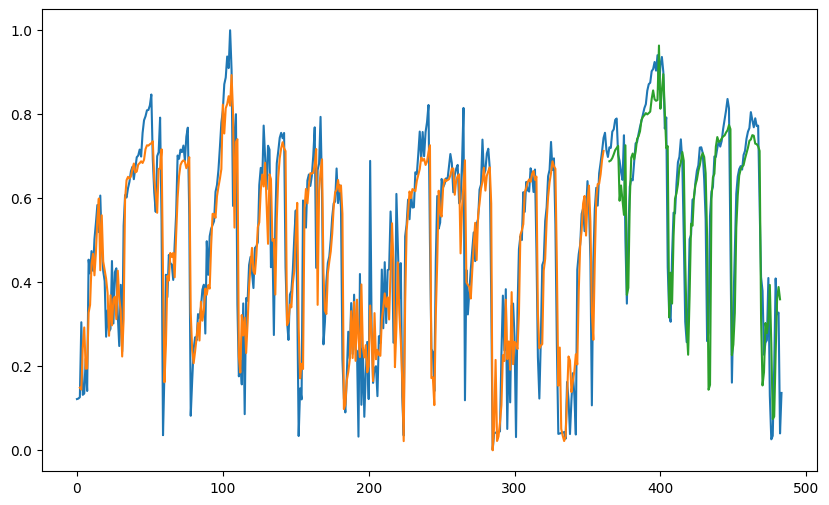

In [85]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset[:,2]).reshape(-1,1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[TIME_STEP:len(train_predict)+TIME_STEP, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset[:,2]).reshape(-1,1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(TIME_STEP*2)+1:len(dataset)-1, :] = test_predict

true_values = (dataset)[:,2].reshape(-1,1)
print(true_values.shape)
print(trainPredictPlot.shape)
# plot baseline and predictions
plt.clf()
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 10})
plt.plot(true_values)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.savefig(f"Model2/{version}/predict.png")
plt.show()